In [68]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot as plt
import pandas as pd
from EarlyStopping import EarlyStopping

torch.manual_seed(0)
np.random.seed(0)

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E)
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)

input_window = 150  # number of input steps
output_window = 1  # number of prediction steps, in this model its fixed to one
batch_size = 512
device = torch.device("cuda")


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=7000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class TransAm(nn.Module):
    def __init__(self, feature_size=300, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size,
                                                        nhead=10,
                                                        dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer,
                                                         num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,
                                          self.src_mask)  #, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(
            mask == 1, float(0.0))
        return mask


# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + output_window:i + tw + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(np.array(inout_seq))


def get_data(name):
    # construct a littel toy dataset
    time = np.arange(0, 400, 0.1)
    data = pd.read_csv('../data/hs300.csv')
    amplitude = data[name].values
    from sklearn.preprocessing import StandardScaler

    #loading weather data from a file
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

    # looks like normalizing input values curtial for the model
    scaler = StandardScaler()
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    sampels = int(len(amplitude)*0.9)
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment..
    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:
                                    -output_window]  #todo: fix hack? -> din't think this through, looks like the last n sequences are to short, so I just remove them. Hackety Hack..

    #test_data = torch.FloatTensor(test_data).view(-1)
    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]  #todo: fix hack?

    return train_sequence.to(device), test_data.to(device),scaler


def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i + seq_len]
    input = torch.stack(
        torch.stack([item[0] for item in data]).chunk(input_window,1))  # 1 is feature size
    target = torch.stack(
        torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target


def train(train_data,epoch,train_losses):
    model.train()  # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()
    

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.8)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size)
        train_losses.append(loss.item())


def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i, 1)
            output = eval_model(data)
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()),
                                    0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)

    #test_result = test_result.cpu().numpy() -> no need to detach stuff..
    len(test_result)

    pyplot.plot(test_result, color="red", label="prediction")
    pyplot.plot(truth[:len(test_result)], color="blue", label="truth")
    pyplot.plot(test_result - truth, color="green", label="error")
    pyplot.legend()
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png' % epoch)
    pyplot.close()

    return total_loss / i


# predict the next n steps based on the input data
def predict_future(eval_model, data_source, steps):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source, 0, 1)
    with torch.no_grad():
        for i in range(0, steps):
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))

    data = data.cpu().view(-1)

    # I used this plot to visualize if the model pics up any long therm structure within the data.
    pyplot.plot(data, color="red")
    pyplot.plot(data[:input_window], color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png' % steps)
    pyplot.close()


def evaluate(eval_model, data_source):
    eval_model.eval()  # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 500
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)


In [69]:
def train_and_get(name):
    input_window = 120  # number of input steps
    output_window = 1  # number of prediction steps, in this model its fixed to one
    batch_size = 800
    device = torch.device("cuda")
    train_data, val_data, scaler = get_data(name)
    global model 
    model = TransAm().to(device)

    global criterion
    criterion = nn.MSELoss()
    lr = 0.0001  # learning rate
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    global optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    global scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.985)

    best_val_loss = float("inf")
    global epochs
    epochs = 500  # The number of epochs
    best_model = None

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=50, verbose=True)

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(train_data,epoch,train_losses)

        if (epoch % 100 == 0):
            val_loss = plot_and_loss(model, val_data, epoch)
            predict_future(model, val_data, 5)
        else:
            val_loss = evaluate(model, val_data)

        valid_losses.append(val_loss)


        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)

        train_losses = []
        valid_losses = []
        
        scheduler.step()

        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    
    def get_predict(eval_model, data_source):
        eval_model.eval()
        total_loss = 0.
        test_result = torch.Tensor(0)
        truth = torch.Tensor(0)
        with torch.no_grad():
            for i in range(0, len(data_source) - 1):
                data, target = get_batch(data_source, i, 1)
                output = eval_model(data)
                total_loss += torch.sqrt(criterion(output, target)).item()
                test_result = torch.cat((test_result, output[-1].view(-1).cpu()),
                                        0)
                truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)

        #test_result = test_result.cpu().numpy() -> no need to detach stuff..
        return scaler.inverse_transform(test_result.view(-1, 1)), scaler.inverse_transform(truth.view(-1, 1))

    
    return get_predict(model, val_data)


In [70]:
result = dict()
for i in ['low_rate','high_rate','close','open','high','low']:
    predict,truth = train_and_get(i)
    result.update({i:predict})
    result.update({i+'_truth':truth})

[  1/500] train_loss: 4.48274 valid_loss: 2.03696
Validation loss decreased (inf --> 2.036965).  Saving model ...
[  2/500] train_loss: 1.48145 valid_loss: 0.55183
Validation loss decreased (2.036965 --> 0.551825).  Saving model ...
[  3/500] train_loss: 1.27192 valid_loss: 0.91734
[  4/500] train_loss: 1.23018 valid_loss: 0.54352
Validation loss decreased (0.551825 --> 0.543520).  Saving model ...
[  5/500] train_loss: 1.13266 valid_loss: 0.55754
[  6/500] train_loss: 0.98315 valid_loss: 0.48622
Validation loss decreased (0.543520 --> 0.486220).  Saving model ...
[  7/500] train_loss: 0.95010 valid_loss: 0.47687
Validation loss decreased (0.486220 --> 0.476873).  Saving model ...
[  8/500] train_loss: 0.95475 valid_loss: 0.59415
[  9/500] train_loss: 1.07765 valid_loss: 0.64679
[ 10/500] train_loss: 0.97200 valid_loss: 0.47988
[ 11/500] train_loss: 0.98381 valid_loss: 0.49914
[ 12/500] train_loss: 1.01632 valid_loss: 0.54248
[ 13/500] train_loss: 0.96519 valid_loss: 0.49607
[ 14/500] 

In [71]:
for i in result.keys():
    result[i] = result[i].reshape(-1)
output = pd.DataFrame(result)

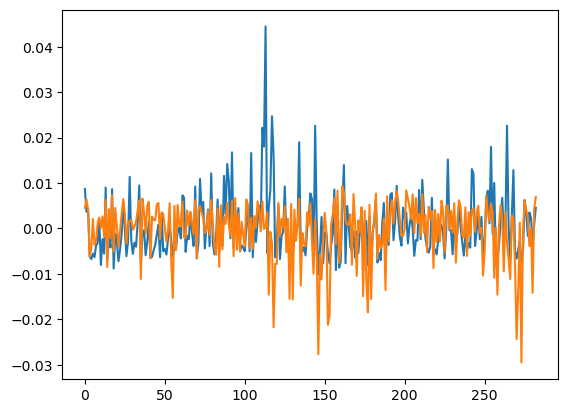

In [72]:
output['low_error'] = output['low_rate'] - output['low_rate_truth']
output['high_error'] = output['high_rate'] - output['high_rate_truth']
pyplot.plot(output['low_error']/output['low_rate_truth'])
pyplot.plot(output['high_error']/output['high_rate_truth'])

In [74]:
output.to_csv('result1.csv',index=False)